In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['year_prediction.csv']


### EDA

In [2]:
df = pd.read_csv("../input/year_prediction.csv")
# Group release years into decades
df['label'] = df.label.apply(lambda year : year-(year%10))

train = df.iloc[:463715]
test = df.iloc[-51630:]

print( train.shape)
train_labels = train['label']
train_features = train.drop("label", axis=1)
test_labels= test['label']
test_features = test.drop("label", axis=1)
train_features.describe()

(463715, 91)


,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,43.385488,1.261091,8.650195,1.130763,-6.512725,-9.565527,-2.384609,-1.793722,3.714584,1.872495,...,15.743361,-73.067753,41.423976,37.780868,0.345259,17.599280,-26.364826,4.444985,19.739307,1.323326
std,6.079139,51.613473,35.264750,16.334672,22.855820,12.836758,14.580245,7.961876,10.579241,6.522868,...,32.086356,175.376872,121.794610,94.874474,16.153797,114.336522,174.187892,13.320996,184.843503,22.045404
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-318.223330
25%,39.957540,-26.153810,-11.441920,-8.515155,-20.636960,-18.468705,-10.776340,-6.461400,-2.303600,-2.448450,...,-1.798085,-139.062035,-20.918635,-4.711470,-6.758160,-31.563615,-101.396245,-2.572830,-59.598030,-8.813335
50%,44.262570,8.371550,10.470520,-0.691610,-5.992740,-11.208850,-2.047850,-1.735440,3.816840,1.775310,...,9.161360,-52.878010,28.709870,33.494550,0.828350,15.554490,-21.123570,3.111120,7.586950,0.052840
75%,47.833650,36.143780,29.741165,8.756995,7.749590,-2.422590,6.515710,2.905130,9.950960,6.128885,...,26.248290,13.620660,89.419995,77.674700,8.495715,67.743725,52.299850,9.948955,86.203115,9.670740
max,61.970140,384.065730,322.851430,289.527430,262.068870,119.815590,172.402680,105.210280,146.297950,60.345350,...,840.973380,4469.454870,3210.701700,1672.647100,260.544900,3662.065650,2833.608950,463.419500,7393.398440,600.766240


In [3]:
any(train_features.isna().sum() > 0)

False

No Null Values

All features seem to be numeric and on different scales. Might be a good idea to standardize the data before doing any modeling.
## Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features.values)
test_features_scaled = scaler.transform(test_features.values)
train_features = pd.DataFrame(train_features_scaled, columns=train_features.columns, index=train_features.index)
test_features = pd.DataFrame(test_features_scaled, columns=test_features.columns, index=test_features.index)

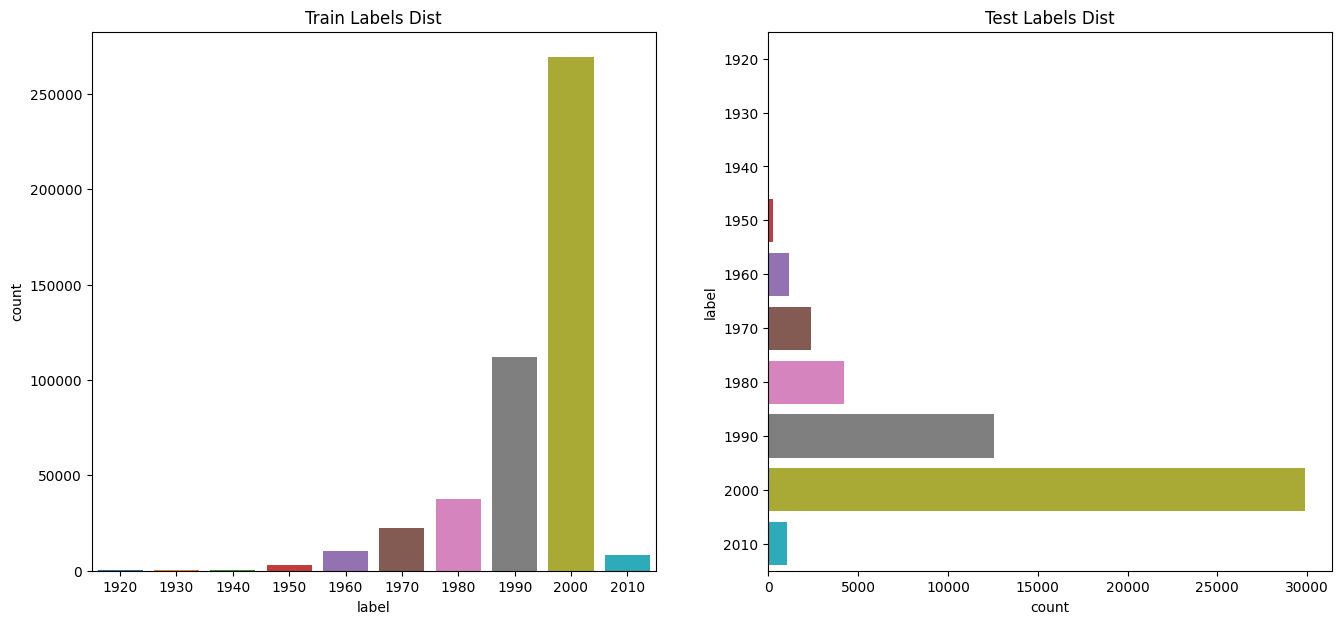

In [5]:
f,ax=plt.subplots(1,2,figsize=(16,7))
sns.countplot(x=train_labels, ax=ax[0])
sns.countplot(y=test_labels, ax=ax[1])
ax[0].set_title("Train Labels Dist")
ax[1].set_title("Test Labels Dist")
plt.show()

* The counts for 1940 and below is too low. Lets exclude those.
*  We might want equal representation accross classes for better performance (stratified sampling).
  - PS - Stratified sampling is turned off in this version. Seems to be harming our scores for some reason.

In [6]:
train = train_features
train['label'] = train_labels
test = test_features
test['label'] = test_labels
print (train_features.shape, test_features.shape)
print (train_labels.shape, test_labels.shape)

train = train[train['label'] > 1940]
test = test[test['label'] > 1940]
# Borrowing Code fr//om https://www.kaggle.com/vinayshanbhag/predict-release-timeframe-from-audio-features for downsampling
min_samples = train.label.value_counts().min() 
decades = train.label.unique()
df_sampled = pd.DataFrame(columns=train.columns)
for decade in decades:
    df_sampled = df_sampled.append(train[train.label==decade].sample((min_samples)))
df_sampled.label = df_sampled.label.astype(int)

train_labels =df_sampled['label']
train_features = df_sampled.drop("label", axis=1)
test_labels= test['label']
test_features = test.drop("label", axis=1)
print (train_features.shape, test_features.shape)
print (train_labels.shape, test_labels.shape)


(463715, 91) (51630, 91)
(463715,) (51630,)


/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_48440/2549636768.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(train[train.label==decade].sample((min_samples)))
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_48440/2549636768.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(train[train.label==decade].sample((min_samples)))
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_48440/2549636768.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(train[train.label==decade].sample((min_samples)))
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_48440/2549636768.py:15: FutureWarning: The f

(19789, 90) (51536, 90)
(19789,) (51536,)


/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_48440/2549636768.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sampled = df_sampled.append(train[train.label==decade].sample((min_samples)))


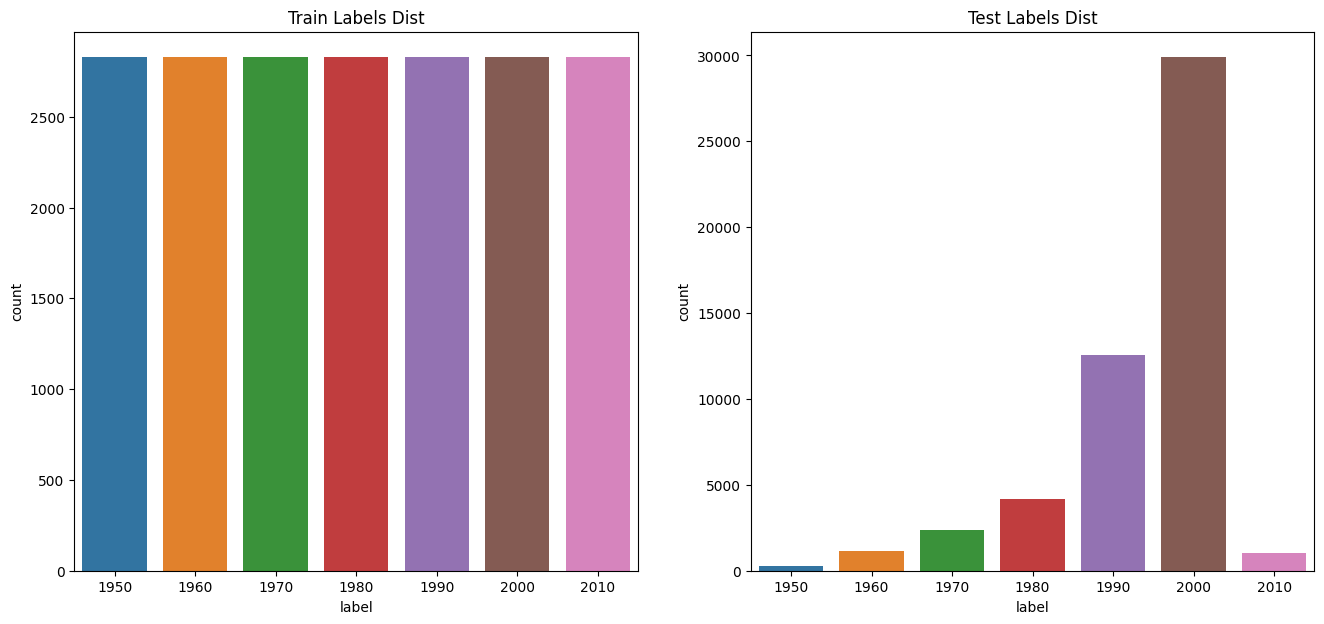

In [7]:
f,ax=plt.subplots(1,2,figsize=(16,7))
sns.countplot(x=train_labels, ax=ax[0])
sns.countplot(x=test_labels, ax=ax[1])
ax[0].set_title("Train Labels Dist")
ax[1].set_title("Test Labels Dist")
plt.show()

## Baseline - Gradient boosting and RandomForest

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [9]:
lgbm = LGBMClassifier()
rf = RandomForestClassifier()
scaler = StandardScaler()
pipeline1 = Pipeline([('scaler', scaler), ('lgbm', lgbm)])
pipeline2 = Pipeline([('scaler', scaler), ('rf', rf)])
print( cross_val_score(pipeline1, train_features, train_labels, cv=5))
print( cross_val_score(pipeline2, train_features, train_labels, cv=5))

[0.43961597 0.44188984 0.44921678 0.44012127 0.43770533]
[0.40879232 0.41839313 0.41435068 0.4110662  0.41799343]


> **** ~14% for LGBM. That's the baseline.

## Neural Nets  Sequential Feedforward Networks

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras as kr
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

2022-12-17 16:50:27.521197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
lb = LabelBinarizer()
trainY = lb.fit_transform(train_labels)
testY = lb.transform(test_labels)
train_features, trainY = shuffle(train_features, trainY)
scaler = StandardScaler()
train_standardized = scaler.fit_transform(train_features)
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=0)
label_count = len(test_labels.unique())

In [15]:
def get_network():
    model = kr.models.Sequential()
    model.add(Dense(20, input_shape=(train_features.shape[1],), activation="relu"))
    model.add(Dense(20, activation="relu"))
    model.add(Dense(label_count, activation="softmax"))
    opt = "adam"
    model.compile(loss= "categorical_crossentropy", optimizer=opt, metrics=["accuracy"], )
    return model

In [16]:
model = get_network()
scikit_net= KerasClassifier(build_fn=get_network, epochs=10, batch_size=40)
print(cross_val_score(scikit_net, train_features, trainY, cv=5))

2022-12-17 16:50:34.048243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/76/d7ytdxx55pbc_thld0wyd29m0000gn/T/ipykernel_28583/1408725817.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  scikit_net= KerasClassifier(build_fn=get_network, epochs=10, batch_size=40)


Epoch 1/10
396/396 [==============================] - 1s 1ms/step - loss: 1.8112 - accuracy: 0.2688
Epoch 2/10
396/396 [==============================] - 0s 1ms/step - loss: 1.5892 - accuracy: 0.3676
Epoch 3/10
396/396 [==============================] - 0s 992us/step - loss: 1.5016 - accuracy: 0.4120
Epoch 4/10
396/396 [==============================] - 0s 1ms/step - loss: 1.4608 - accuracy: 0.4230
Epoch 5/10
396/396 [==============================] - 2s 4ms/step - loss: 1.4369 - accuracy: 0.4354
Epoch 6/10
396/396 [==============================] - 2s 4ms/step - loss: 1.4199 - accuracy: 0.4424
Epoch 7/10
396/396 [==============================] - 1s 3ms/step - loss: 1.4060 - accuracy: 0.4470
Epoch 8/10
396/396 [==============================] - 1s 3ms/step - loss: 1.3956 - accuracy: 0.4532
Epoch 9/10
396/396 [==============================] - 1s 4ms/step - loss: 1.3860 - accuracy: 0.4564
Epoch 10/10
99/99 [==============================] - 1s 2ms/step - loss: 1.4560 - accuracy: 0.4318

Seems like with 1 input layer and 1 hidden layer each with 20 nodes we get close to the baseline. 

## Active questions
- Are those features time dependent/based on slices of time?
- How do you decide a neural net architecture?
    - You don't. All trial and error. 
- How do you get things like feature importance in a Neural Net?
- Standardization seems very important to Neural nets. Why? What effects to stratified samples have?
  - Ans: Equal representation across classes prevents the classifier from being biased towards the majority class. Might mean lesser raw accuracy but a confusion matrix that looks much better

In [17]:
from sklearn.metrics import accuracy_score
print("LGB accuracy")
pipeline1.fit(train_features, train_labels)
print(accuracy_score(pipeline1.predict(test_features), test_labels))
print("RF accuracy")
pipeline2.fit(train_features, train_labels)
print(accuracy_score(pipeline2.predict(test_features), test_labels))
model.fit(train_features, trainY, batch_size=40, epochs=5)
model.evaluate(test_features, testY)

LGB accuracy
0.1354587084756287
RF accuracy
0.13136448307978887
Epoch 1/5
495/495 [==============================] - 2s 2ms/step - loss: 1.7789 - accuracy: 0.2832
Epoch 2/5
495/495 [==============================] - 1s 2ms/step - loss: 1.5559 - accuracy: 0.3840
Epoch 3/5
495/495 [==============================] - 1s 2ms/step - loss: 1.4834 - accuracy: 0.4136
Epoch 4/5
495/495 [==============================] - 1s 2ms/step - loss: 1.4484 - accuracy: 0.4278
Epoch 5/5
1611/1611 [==============================] - 2s 1ms/step - loss: 1.6003 - accuracy: 0.2439


[1.6003029346466064, 0.2438877671957016]

In [18]:
preds = model.predict(test_features)

1611/1611 [==============================] - 2s 935us/step


In [19]:
pred_single = [i.argmax() for i in preds]
label_single = [i.argmax() for i in testY]

<AxesSubplot: >

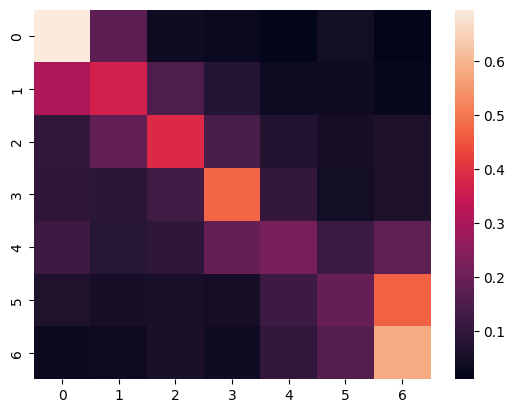

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_single, pred_single)
cm_df= pd.DataFrame(cm)
cm_df = cm_df.apply(lambda x: x/sum(x), axis ='columns')
sns.heatmap(cm_df)

So it seems like from the 50s ot the 80s we're doing well. What we're failing at is the later stages where we ironically have more data. Maybe try a differnet sampling method to use all the data we have?

In [21]:
cm_df

,0,1,2,3,4,5,6
0,0.694545,0.174545,0.036364,0.029091,0.010909,0.043636,0.010909
1,0.304460,0.367925,0.151801,0.079760,0.036021,0.036021,0.024014
2,0.099750,0.183639,0.387312,0.142738,0.073038,0.050501,0.063022
3,0.096882,0.090455,0.130921,0.473221,0.102595,0.043085,0.062842
4,0.118998,0.081320,0.094674,0.192051,0.218680,0.117011,0.177266
5,0.066789,0.051196,0.054241,0.049557,0.118956,0.190162,0.469098
6,0.029042,0.034850,0.057115,0.036786,0.101646,0.160697,0.579864
